# Text Clustering
In this project we will perform a text classification on the health tweets text using kmeans clustering. The health tweets provide a large dataset to test many types of text clustering, from kmeans to kmedians, to LSA and LDA.
    
The code, along with the files necessary and versions of packages in this instance can be found on this repo: https://github.com/Benjamin-Siebold/MSDS-682-Text-Analytics

In [1]:
import time
from glob import iglob
import spacy
import nltk
import string
import re

import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
from matplotlib import pyplot as plt
%matplotlib inline

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

nlp = spacy.load('en_core_web_lg')
stopwords = nltk.corpus.stopwords.words('english')
np.random.seed(50)

# 1 - Load data and prepare text
The first step in this analysis is to load the data in with iglob, and clean the tweets to lemmatize, change words to lowercase, and remove stopwords in order to cluster the data most accurately. Because the amount of tweets (62,000) is so large, the cleaning function and clustering can take an extremely long time. One option to  this time taken is to multiprocess the cleaning portion of the tweets by either pooling them, or creating a managed list in the multiprocessing package. Another option is to take a sample of the tweets for analysis. The latter was chosen for this project.

In [2]:
news_files = []
for file in list(iglob('Health-Tweets/*.txt')):
    news_files.append(pd.read_csv(file, sep= '|', header=None, error_bad_lines=False, encoding='latin-1'))

news_df = pd.concat(news_files)

b'Skipping line 846: expected 3 fields, saw 4\nSkipping line 904: expected 3 fields, saw 4\nSkipping line 914: expected 3 fields, saw 4\nSkipping line 1264: expected 3 fields, saw 4\nSkipping line 1269: expected 3 fields, saw 4\nSkipping line 1293: expected 3 fields, saw 4\nSkipping line 1348: expected 3 fields, saw 4\nSkipping line 1430: expected 3 fields, saw 4\nSkipping line 1486: expected 3 fields, saw 4\nSkipping line 1710: expected 3 fields, saw 4\nSkipping line 2699: expected 3 fields, saw 4\nSkipping line 2728: expected 3 fields, saw 4\nSkipping line 3000: expected 3 fields, saw 4\n'
b'Skipping line 4015: expected 3 fields, saw 4\nSkipping line 6118: expected 3 fields, saw 4\nSkipping line 6354: expected 3 fields, saw 4\nSkipping line 6429: expected 3 fields, saw 4\nSkipping line 6528: expected 3 fields, saw 4\nSkipping line 6930: expected 3 fields, saw 4\nSkipping line 6944: expected 3 fields, saw 4\nSkipping line 6948: expected 3 fields, saw 4\nSkipping line 6949: expected 3 

In [3]:
news_df.columns = ['id','date','tweet']

In [4]:
news_df

,id,date,tweet
0,586266687948881921,Thu Apr 09 20:37:25 +0000 2015,Drugs need careful monitoring for expiry dates...
1,586266687017771008,Thu Apr 09 20:37:25 +0000 2015,Sabra hummus recalled in U.S. http://www.cbc.c...
2,586266685495214080,Thu Apr 09 20:37:24 +0000 2015,U.S. sperm bank sued by Canadian couple didn't...
3,586226316820623360,Thu Apr 09 17:57:00 +0000 2015,Manitoba pharmacists want clampdown on Tylenol...
4,586164344452354048,Thu Apr 09 13:50:44 +0000 2015,Mom of 7 'spooked' by vaccinations reverses st...
...,...,...,...
3194,106106376224378880,Tue Aug 23 20:51:46 +0000 2011,Mainstay Meds Often Cut Off Accidentally After...
3195,106106374735400960,Tue Aug 23 20:51:45 +0000 2011,Injectable Psoriasis Drugs May Not Hike Heart ...
3196,106106373275787264,Tue Aug 23 20:51:45 +0000 2011,Certain Foods Said to Help Lower Bad Cholester...
3197,106106371736485889,Tue Aug 23 20:51:45 +0000 2011,Boys Mature Sexually Earlier Than Ever Before:...


In [5]:
stopwords = set(stopwords + ['RT', 'Health', 'Healthcare', 'health', 'healthcare'])

In [6]:
def clean_text(docs):
    
    #print('remove https')
    docs = [re.sub(r'http\S+', '', doc).rstrip() for doc in docs]
    docs = [re.sub(r'@\S+', '', doc) for doc in docs]
    
    print('removing punc')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in docs]
    
    print('nlp')
    nlp_docs = [nlp(doc) for doc in clean_docs]
    
    print('lemmatize')
    lemm_docs = [[w.lower_ if w.lemma_ == '-PRON-' 
                  else w.lemma_ for w in doc]
                for doc in nlp_docs]
    
    print('remove stopwords')
    lemm_docs = [[lemma for lemma in doc if lemma not in stopwords] for doc in lemm_docs]
    
    print('combine words')
    cleaned_docs = [' '.join(word) for word in lemm_docs]
    
    return cleaned_docs

In [7]:
tweet_sample = news_df['tweet'].sample(5000)

In [8]:
cleaned_tweets = clean_text(tweet_sample)

removing punc
nlp
lemmatize
remove stopwords
combine words


In [9]:
tweets_no_special = []
for r in cleaned_tweets:
    tweets_no_special.append(r.encode('ascii','ignore').decode('ascii'))   

# 2 - Tranform Data and apply model
Now that the data is cleaned, we transform the data using TfidfVectorizer, and apply a KMeans model to the data. Once that is done, we check the score, and then create an iteration of models in order to build a plot to determine which amount of clusters is the most optimal. This spot occurs where the data starts to flatten out for the sum of squared distances between points and their centers, or by plotting the derivative of the within sum of squares (wss) to see where it flattens.

In [10]:
vectorizer = TfidfVectorizer(min_df=100)
features = vectorizer.fit_transform(tweets_no_special)
type(features)

scipy.sparse.csr.csr_matrix

In [11]:
features.shape

(5000, 27)

In [12]:
features = features.todense()

In [13]:
model = KMeans(n_clusters=10, random_state=50, n_jobs=-1)

In [14]:
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [15]:
model.score(features)

-1721.261590397848

In [16]:
wss = []
for n in range(2, 50):
    model = KMeans(n_clusters=n, random_state=50, n_jobs=-1)
    model.fit(features)
    wss.append(-model.score(features))

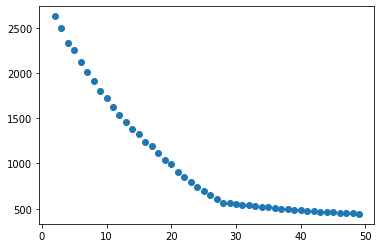

In [17]:
plt.scatter(range(2,50),wss)

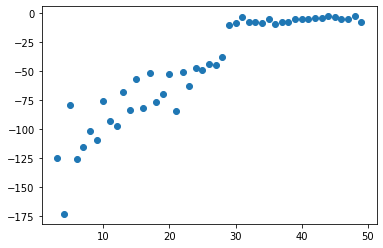

In [18]:
plt.scatter(range(3,50), np.diff(wss))

# 3 - Apply best model
From the plots above, we can see for the most part the best model to apply to this data has 28 clusters. With this known, we create a model, and cluster the data accordingly, predicting our features, and then tying each tweet back to a cluster.

In [19]:
model = KMeans(n_clusters=28, random_state=50, n_jobs=-1)
model.fit(features)
cluster_labels = model.predict(features)

In [20]:
np.bincount(cluster_labels)

array([ 110, 2072,  123,  103,  114,  162,  129,  109,  100,  102,  103,
        138,  105,  124,  102,   90,  101,  105,  108,   79,  111,  116,
        120,   94,  105,   87,   92,   96])

In [21]:
tweet_df = pd.DataFrame(np.array(tweets_no_special),columns=['tweet'])
clusters_df = pd.DataFrame(cluster_labels,columns=['prediction'])

In [22]:
tweets_clustered = pd.concat([tweet_df,clusters_df], axis=1,join='inner')
tweets_clustered

,tweet,prediction
0,abduction survivor humanfactor,1
1,manage chronic condition workplace,1
2,Amish seek Measles shot Ohio Outbreak sicken,1
3,Boston Hospitals Share lesson Marathon bombing,1
4,Pfizer buy two Baxter vaccine mln,1
...,...,...
4995,thank share story us cmvmatter,6
4996,HIV diagnosis rate fall third US researcher,6
4997,inspire weightloss story Boy meet girl lose ne...,1
4998,nurse Ebola Amber Vinson travel plane day repo...,24


In [23]:
tweets_clustered.groupby(['prediction']).head(5).sort_values(by=['prediction'])

,tweet,prediction
153,food eat long life,0
140,well trendy Food Kosher Passover,0
197,young kid food allergy may learn helplessness,0
265,FDA propose strict new safety rule animal food,0
12,feel bloated lil gassy top gasproduce food avoid,0
0,abduction survivor humanfactor,1
3,Boston Hospitals Share lesson Marathon bombing,1
1,manage chronic condition workplace,1
4,Pfizer buy two Baxter vaccine mln,1
2,Amish seek Measles shot Ohio Outbreak sicken,1


# 4 - Analyze data
The last step in the analysis is to look into what kind of clustering took place of the tweets. We once again take a sample of the 5,000 tweets to see if we can find a general understanding for how the clusters were done. From above, it can be seen there are still potential flaws with the clustering. For example cluster 6 has almost now relation between the examples, but US is found multiple times, suggesting either that cluster is focused on the US location and it potentially would've been beneficial to remove additional stopwords.